<a href="https://colab.research.google.com/github/Mariamibrahim223/Chen_plasma_physics/blob/main/Proj_Ch8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.fft import fft, ifft, fftfreq
from pathlib import Path
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import imageio.v2 as imageio   # for making GIFs
import os

# Wave Steeping

A great example for wave-steeping is solutions of Burgers' equation using Lax-Friedrichs scheme

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0
$$

We use it in the form:
$$
\frac{\partial S}{\partial t} + \frac{\partial F}{\partial x} = 0
$$

$$
\frac{\partial S}{\partial t} = \frac{S_i^{n+1} - S_i^n}{\Delta t}, \qquad
\frac{\partial F}{\partial t} = \frac{F_i^{n} - F_{i-1}^n}{\Delta x}
$$

where $F$ is the flux, and $S$ is the source. In our case:

$$
S = u, \qquad F = \frac{1}{2} u^2
$$

After discretizing spave and time, the Lax-Friedrichs update is:

$$
\frac{u_i^{n+1} - u_i^n}{\Delta t} + \frac{(u_i^{n})^2 - (u_{i-1}^n)^2}{2\Delta x} = 0
$$

$$
u_i^{n+1} = u_i^n + \frac{\Delta t}{2\Delta x} ((u_i^{n})^2 - (u_{i-1}^n)^2)
$$


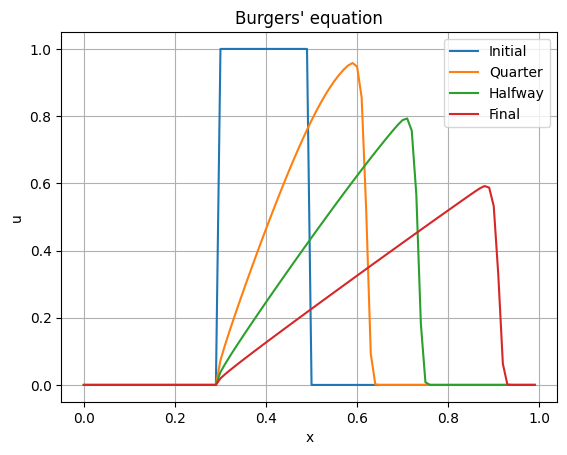

In [ ]:
# Parameters
c = 1.0
dx = 1e-2
dt = 1e-3
L = 1.0
T = 1.0

# Derived
x = np.arange(0, L, dx)
t = np.arange(0, T, dt)
nx = len(x)
nt = len(t)
CN = (dt/(2* dx))

# Initialize u: shape (nt, nx)
u = np.zeros((nt, nx))

# Initial condition (e.g., square pulse in center)
u[0, int(nx*0.3):int(nx*0.5)] = 1.0

# Time-stepping loop
for n in range(0, nt - 1):
    for i in range(1, nx):
        u[n+1, i] = u[n, i] - CN * ((u[n, i])**2 - (u[n, i-1])**2)

# Plot result
plt.plot(x, u[0], label='Initial')
plt.plot(x, u[nt//4], label='Quarter')
plt.plot(x, u[nt//2], label='Halfway')
plt.plot(x, u[-1], label='Final')
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title("Burgers' equation")
plt.grid(True)
plt.show()

# Oscillating Two-stream instability

This case of two-stream instability causing a trapping for particles inside its wells. We will use the same PIC method we used in Ch6 Projects.

In [ ]:
def CIC(pos, E_grid, N_x, L, q_particle):
    dx = L / N_x
    Np = pos.size
    j = np.floor(pos / dx).astype(int).flatten()
    jp1 = (j + 1) % N_x
    wt_jp1 = ((pos - j * dx) / dx).flatten()
    wt_j = (1.0 - wt_jp1).flatten()
    n_counts = np.bincount(j, weights=wt_j, minlength=N_x) + \
               np.bincount(jp1, weights=wt_jp1, minlength=N_x)
    n_grid = n_counts * (q_particle / dx)
    Ep = wt_j * E_grid[j] + wt_jp1 * E_grid[jp1]
    return Ep

def poisson_fft(n_grid, n0, L):
    Nx = n_grid.size
    dx = L / Nx
    rho = n_grid - n0
    rho -= np.mean(rho)
    rho_k = np.fft.rfft(rho)
    k = 2.0 * np.pi * np.fft.rfftfreq(Nx, d=dx)
    phi_k = np.zeros_like(rho_k, dtype=complex)
    nonzero = k != 0.0
    phi_k[nonzero] = - rho_k[nonzero] / (k[nonzero]**2)
    phi = np.fft.irfft(phi_k, n=Nx)
    E_k = -1j * k * phi_k
    E_grid = np.fft.irfft(E_k, n=Nx)
    return E_grid, phi

def acc(F, m):
    return F / m

In [ ]:
def Osc_two_stream_instability():
    # Parameters
    N, Nx, L = 40000, 400, 50
    tEnd, dt = 150, 1
    n0, vb, vth, A, q, m = 1, 3, 0.5, 0.9, -1, 1
    Nt, Nh = int(np.ceil(tEnd / dt)), int(N/2)
    dx = L / Nx

    # Initial conditions
    np.random.seed(42)
    pos = np.random.rand(N,1) * L
    vel = vth * np.random.randn(N,1) + vb
    vel[Nh:] = vth * np.random.randn(Nh,1) - vb
    vel *= 1 + A * np.sin(2 * np.pi * pos / L)

    # Initial density
    n_grid = np.bincount(np.floor(pos.flatten() / dx).astype(int),
                         weights=(1.0 - (pos.flatten() - np.floor(pos.flatten() / dx) * dx) / dx),
                         minlength=Nx) + \
             np.bincount((np.floor(pos.flatten() / dx).astype(int) + 1) % Nx,
                         weights=((pos.flatten() - np.floor(pos.flatten() / dx) * dx) / dx),
                         minlength=Nx)
    n_grid *= (n0 * L / N) / dx

    E_grid, phi = poisson_fft(n_grid, n0, L)
    Ep = CIC(pos.flatten(), E_grid, Nx, L, q)
    F = q * Ep
    a = acc(F, m)
    vel += 0.5 * a.reshape(-1, 1) * dt

    # Folder for frames
    if not os.path.exists("frames"):
        os.makedirs("frames")

    frames = []
    t = 0
    for i in range(Nt):
        pos += vel * dt
        pos = np.mod(pos, L)

        n_grid = np.bincount(np.floor(pos.flatten() / dx).astype(int),
                             weights=(1.0 - (pos.flatten() - np.floor(pos.flatten() / dx) * dx) / dx),
                             minlength=Nx) + \
                 np.bincount((np.floor(pos.flatten() / dx).astype(int) + 1) % Nx,
                             weights=((pos.flatten() - np.floor(pos.flatten() / dx) * dx) / dx),
                             minlength=Nx)
        n_grid *= (n0 * L / N) / dx

        E_grid, phi = poisson_fft(n_grid, n0, L)
        Ep = CIC(pos.flatten(), E_grid, Nx, L, q)
        F = q * Ep
        a = acc(F, m)
        vel += a.reshape(-1, 1) * dt / 2.0
        t += dt

        # Save frames every few steps
        if i % 2 == 0:
            fig, ax = plt.subplots(figsize=(6,4))
            ax.scatter(pos[0:Nh], vel[0:Nh], s=0.4, color="blue", alpha=0.5)
            ax.scatter(pos[Nh:], vel[Nh:], s=0.4, color="red", alpha=0.5)
            ax.set_xlim(0, L)
            ax.set_ylim(-6, 6)
            ax.set_xlabel("x")
            ax.set_ylabel("v")
            ax.set_title(f"Oscillating Two-Stream Instability t={t:.1f}")
            frame_path = f"frames/frame_{i:04d}.png"
            plt.savefig(frame_path, dpi=100)
            plt.close()
            frames.append(frame_path)

    # Make GIF
    images = [imageio.imread(f) for f in frames]
    imageio.mimsave("osctwostream.gif", images, duration=0.15)

if __name__ == "__main__":
    Osc_two_stream_instability()

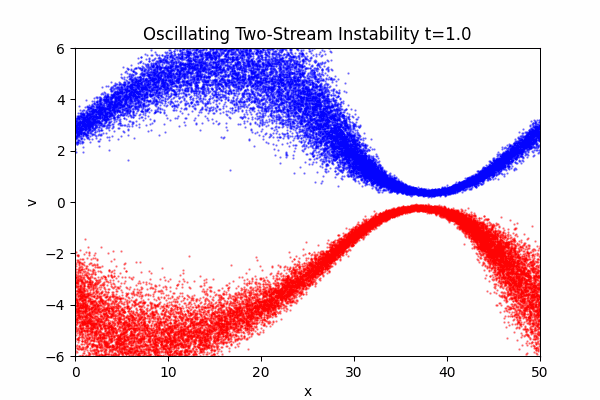

In [ ]:
from IPython.display import Image
Image(filename="osctwostream.gif")

# Parametric decay instability

# Plasma Echoes

# Nonlinear Landau Damping

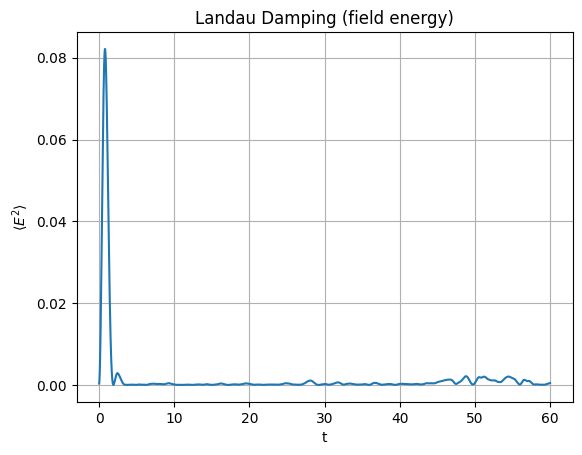

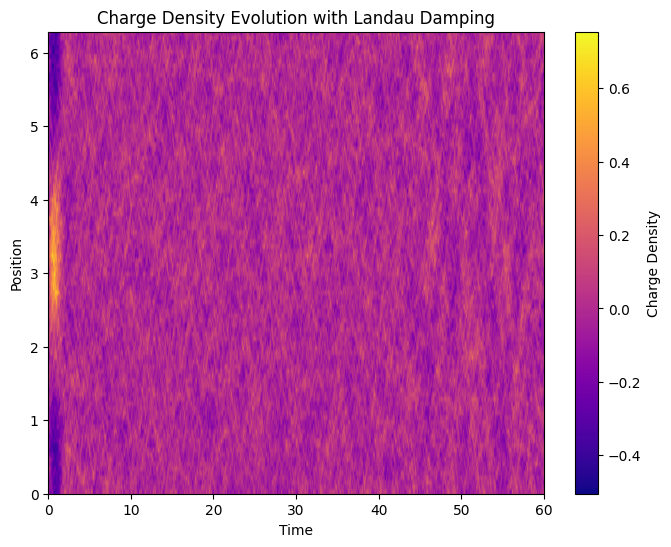

In [ ]:
def NL_landau_damping():
    # Simulation Parameters
    N = 10000
    Nx = 100
    t = 0.0
    tEnd = 60.0
    dt = 0.01
    L = 2 * np.pi
    n0 = 1.0
    vth = 1.0
    A = 0.8
    q = -1.0
    m = 1.0
    plotRealTime = True

    dx = L / Nx
    Nt = int(np.ceil(tEnd / dt))

    # Initial Conditions
    np.random.seed(42)
    pos = np.random.rand(N) * L
    vel = np.random.normal(0, vth, N)
    vel += A * np.sin(pos)  # velocity perturbation

    # Initial density (CIC)
    n_grid = np.bincount(np.floor(pos.flatten() / dx).astype(int),
                         weights=(1.0 - (pos.flatten() - np.floor(pos.flatten() / dx) * dx) / dx),
                         minlength=Nx) + \
             np.bincount((np.floor(pos.flatten() / dx).astype(int) + 1) % Nx,
                         weights=((pos.flatten() - np.floor(pos.flatten() / dx) * dx) / dx),
                         minlength=Nx)
    n_grid *= (n0 * L / N) / dx

    # Field
    E_grid, phi = poisson_fft(n_grid, n0, L)
    Ep = CIC(pos.flatten(), E_grid, Nx, L, q)
    F = q * Ep

    # Diagnostics storage
    E_hist, t_hist = [], []
    density_time = np.zeros((Nt, Nx))   # store charge density at each step

    # Main Loop
    for i in range(Nt):
        # deposit (CIC)
        n_grid = np.bincount(np.floor(pos.flatten() / dx).astype(int),
                             weights=(1.0 - (pos.flatten() - np.floor(pos.flatten() / dx) * dx) / dx),
                             minlength=Nx) + \
                 np.bincount((np.floor(pos.flatten() / dx).astype(int) + 1) % Nx,
                         weights=((pos.flatten() - np.floor(pos.flatten() / dx) * dx) / dx),
                         minlength=Nx)
        n_grid *= (n0 * L / N) / dx

        # store density snapshot
        density_time[i, :] = n_grid - n0

        # field solve (FFT)
        E_grid, phi = poisson_fft(n_grid, n0, L)

        # gather and full kick
        Ep = CIC(pos.flatten(), E_grid, Nx, L, q)
        F = q * Ep
        a = acc(F, m)

        vel += a * dt
        pos += vel * dt
        pos = np.mod(pos, L)

        t += dt

        # store field energy
        E_hist.append(np.mean(E_grid**2))
        t_hist.append(t)

    # Field energy vs time (should decay ~exponentially)
    plt.figure()
    plt.plot(t_hist, E_hist)
    plt.xlabel("t"); plt.ylabel(r"$\langle E^2 \rangle$")
    plt.title("Landau Damping (field energy)")
    plt.grid(True, which='both')
    plt.show()

    # Heatmap of charge density evolution
    plt.figure(figsize=(8, 6))
    plt.imshow(density_time.T, aspect='auto', cmap='plasma',
               extent=[0, Nt*dt, 0, L], origin='lower')
    plt.colorbar(label='Charge Density')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title('Charge Density Evolution with Landau Damping')
    plt.show()

if __name__ == "__main__":
    NL_landau_damping()

# Korteweg-de Vries Equation

$$
\frac{\partial U}{\partial \tau} + A U \frac{\partial U}{\partial \xi} + B \frac{\partial^3 U}{\partial \xi^3} = 0
$$

We discretize the space and time

$$
x_j = j \Delta x, \quad j = 0, 1, \cdots , N-1, \quad \Delta x = \frac{L}{N}
$$

$$
t^n = n\Delta t, \quad n = 0,1, \cdots, M \quad \Delta t = \frac{T}{M}
$$

$$
u_x = \frac{u^n_{j+1} - u^n_{j-1}}{2\Delta x}
$$

$$
u_{xxx} = \frac{u^n_{j-2} - 2u^n_{j-1} + 2 u^n_{j+1} - u^n_{j+2}}{2(\Delta x)^3}
$$

So:

$$
\frac{du_j}{dt} = -A u_j \frac{u^n_{j+1} - u^n_{j-1}}{2\Delta x} - B \frac{u^n_{j-2} - 2u^n_{j-1} + 2 u^n_{j+1} - u^n_{j+2}}{2(\Delta x)^3}
$$

For the time-integration, we use the fourth Runge-Kutta scheme:

For a general system:
$$
\frac{du}{dt} = F(u,t)
$$

$$
u^{n+1} = u^n + \frac{\Delta t}{6} (k_1 + 2k_2 + 2k_3 + k_4)
$$

where:
$$
k_1 = F(u^n, t^n)
$$
$$
k_2 = F(u^n + \frac{\Delta t}{2} k_1, t^n + \frac{\Delta t}{2})
$$
$$
k_3 = F(u^n + \frac{\Delta t}{2} k_2, t^n + \frac{\Delta t}{2})
$$
$$
k_4 = F(u^n + \frac{\Delta t}{2} k_3, t^n + \Delta t)
$$



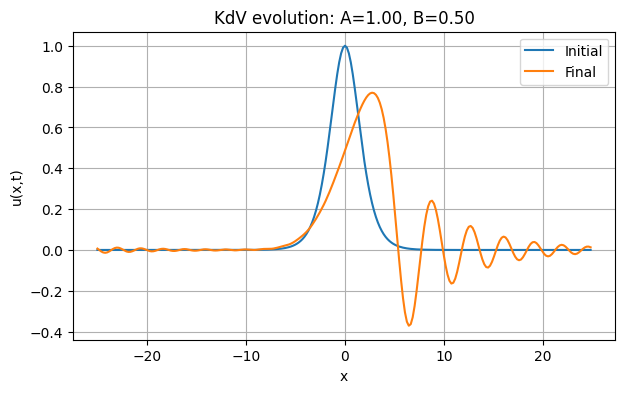

Used parameters: A=1.00, B=0.50


In [ ]:
def kdv_solver(A, B, N=256, L=50.0, T=3.0, dt=1e-3, visualize=True):
    """
    Solve the KdV equation using finite differences in space and RK4 in time.

    Parameters
    ----------
    A, B (floats): KdV coefficients.
    N (int): Number of grid points.
    L (float): Domain length.
    T (float): Total simulation time.
    dt (float): Time step.
    visualize (bool): Plot initial and final states if True.

    Returns
    -------
    frames : ndarray
        Array containing the solution at different time points.
    times : ndarray
        Time points corresponding to the frames.
    xi : ndarray
        Spatial grid.
    params : dict
        Dictionary containing the parameters used (A, B, etc.).
    """

    # Parameters
    params = {"A": A, "B": B, "N": N, "L": L, "T": T, "dt": dt}

    # Spatial grid
    dx = L / N
    xi = np.linspace(-L/2, L/2 - dx, N)  # periodic domain

    # Initial condition: sech^2 packet
    u0 = A * (1/np.cosh(B * xi))**2

    # Finite Difference RHS
    def rhs(u):
        """Right-hand side of KdV equation using FD derivatives."""
        # periodic BCs with np.roll
        u_p1 = np.roll(u, -1)
        u_m1 = np.roll(u, 1)
        u_p2 = np.roll(u, -2)
        u_m2 = np.roll(u, 2)

        # First derivative
        ux = (u_p1 - u_m1) / (2*dx)

        # Third derivative
        uxxx = (u_m2 - 2*u_m1 + 2*u_p1 - u_p2) / (2*dx**3)

        return -A * u * ux - B * uxxx

    # RK4 Step
    def rk4_step(u, dt):
        k1 = rhs(u)
        k2 = rhs(u + 0.5*dt*k1)
        k3 = rhs(u + 0.5*dt*k2)
        k4 = rhs(u + dt*k3)
        return u + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    # Time integration
    nt = int(T / dt)
    u = u0.copy()
    save_every = max(1, nt // 200)  # store ~200 frames
    frames, times = [], []

    for n in range(nt+1):
        if n % save_every == 0:
            frames.append(u.copy())
            times.append(n*dt)
        u = rk4_step(u, dt)

    frames = np.array(frames)
    times = np.array(times)

    # Visualization
    if visualize:
        plt.figure(figsize=(7,4))
        plt.plot(xi, u0, label="Initial")
        plt.plot(xi, u, label="Final")
        plt.xlabel("x")
        plt.ylabel("u(x,t)")
        plt.title(f"KdV evolution: A={A:.2f}, B={B:.2f}")
        plt.legend()
        plt.grid()
        plt.show()

    return frames, times, xi, params

if __name__ == "__main__":
    frames, times, xi, params = kdv_solver(A=1, B=0.5)
    print(f"Used parameters: A={params['A']:.2f}, B={params['B']:.2f}")


# Non-linear Shrodinger Equation

$$
i \frac{\partial \psi}{\partial t} + p \frac{\partial^2 \psi}{\partial x^2} + q |\psi|^2 \psi + \Delta u = 0
$$




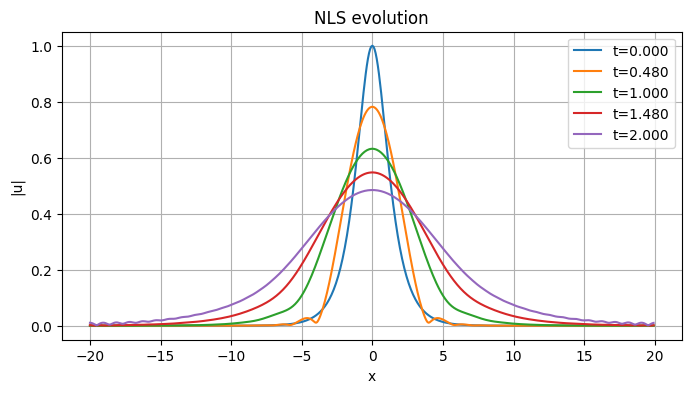

In [ ]:
def NLS_solver(u0_func, L=40.0, N=512, dt=0.002, tmax=2.0, save_every=20,
                      p=1.5, q=-0.01, Delta=0.0):
    """
    Solve the cubic NLS equation using finite differences in space and RK4 in time:
        i u_t + p u_xx + q |u|^2 u + Delta u = 0

    Parameters
    ----------
    u0_func : function
        Initial condition function u(x).
    L : float
        Spatial domain length (-L/2 to L/2).
    N : int
        Number of spatial points.
    dt : float
        Time step.
    tmax : float
        Final simulation time.
    save_every : int
        Save data every 'save_every' steps.
    p, q, Delta : floats
        NLS coefficients.

    Returns
    -------
    x : array
        Spatial grid.
    times : array
        Saved times.
    intensity_map : 2D array
        |u(x,t)|^2 values at saved times.
    """

    # Spatial grid
    dx = L / N
    x = np.linspace(-L/2, L/2 - dx, N)

    # Initial condition
    u = u0_func(x).astype(np.complex128)

    # ---- RHS of NLS ----
    def rhs(u):
        # Periodic BCs
        u_p1 = np.roll(u, -1)
        u_m1 = np.roll(u, 1)

        # Second derivative (central difference)
        u_xx = (u_p1 - 2*u + u_m1) / dx**2

        return 1j * (-p * u_xx - q * np.abs(u)**2 * u - Delta * u)

    # ---- RK4 Step ----
    def rk4_step(u, dt):
        k1 = rhs(u)
        k2 = rhs(u + 0.5*dt*k1)
        k3 = rhs(u + 0.5*dt*k2)
        k4 = rhs(u + dt*k3)
        return u + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    # ---- Time loop ----
    nsteps = int(np.round(tmax / dt))
    n_frames_est = nsteps // save_every + 1
    intensity_map = np.zeros((n_frames_est, N))
    times = np.zeros(n_frames_est)

    frame_idx = 0
    intensity_map[frame_idx, :] = np.abs(u)**2
    times[frame_idx] = 0.0
    frame_idx += 1

    for istep in range(1, nsteps+1):
        u = rk4_step(u, dt)

        if istep % save_every == 0:
            intensity_map[frame_idx, :] = np.abs(u)**2
            times[frame_idx] = istep * dt
            frame_idx += 1

    # ---- Visualization ----
    snap_times = np.linspace(0, times[frame_idx-1], min(5, frame_idx))
    snap_indices = [np.argmin(np.abs(times[:frame_idx] - st)) for st in snap_times]

    plt.figure(figsize=(8,4))
    for idx in snap_indices:
        plt.plot(x, np.sqrt(intensity_map[idx, :]))
    plt.xlabel('x')
    plt.ylabel('|u|')
    plt.title("NLS evolution")
    plt.legend([f"t={times[idx]:.3f}" for idx in snap_indices])
    plt.grid()
    plt.show()

    return x, times[:frame_idx], intensity_map[:frame_idx, :]


# Example usage
if __name__ == "__main__":
    # Example initial condition: soliton-like pulse
    A0 = 1.0
    width = 1.0
    def u0_func(x):
        return A0 / np.cosh(x/width)

    x, times, intensity = NLS_solver(
        u0_func,
        L=40.0, N=512,
        dt=0.002, tmax=2.0, save_every=20,
        p=1.5, q=-0.125*0.01/(1.2**2 - 0.01),
        Delta=0.0
    )
